In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import tqdm
import scipy
import umap
import torch
import copy

from methods import RandomWalk2D, place_cells, border_cells, head_direction_cells, HexagonalGCs

In [3]:
boxsize=3*np.pi
mesh = np.linspace(-boxsize, boxsize, 100)
X, Y = np.meshgrid(mesh, mesh)
mesh = np.stack([X, Y], axis=-1)

ncells=100
grids = HexagonalGCs(ncells=ncells, f=1/(2.5*np.pi))


rw = RandomWalk2D()
rs_trajectory, vs = rw.generate_data(1, 100)
# ----
rs_trajectory = np.zeros_like(rs_trajectory)
dt=1e-2*3
rs_trajectory[1:] = np.cumsum(np.tile(grids.unit_cell.basis[0]*dt, (len(rs_trajectory)-1, 1)), axis=0)
# concatenate trajectory along basis 1 and 2 as well
rs_trajectory2 = np.zeros_like(rs_trajectory)
rs_trajectory2[1:] = np.cumsum(np.tile(grids.unit_cell.basis[1]*dt, (len(rs_trajectory)-1, 1)), axis=0)
rs_trajectory3 = np.zeros_like(rs_trajectory)
rs_trajectory3[1:] = np.cumsum(np.tile(grids.unit_cell.basis[2]*dt, (len(rs_trajectory)-1, 1)), axis=0)
# ----
rs_square_mesh = mesh.reshape(-1, 2)
# ----
rs = grids.unit_cell.mesh(50)

In [4]:
mask = np.linalg.norm(rs, axis=-1) < 0#boxsize/4
activities = grids(torch.tensor(rs[~mask]).float()).detach().numpy()
#activities = border_cells(rs[~mask], phases=ncells)
#activities = place_cells(rs[~mask], phases=ncells)
umap_map = umap.UMAP(n_components=3, n_neighbors=300).fit(activities)
low_dim_activities = umap_map.transform(activities)
low_dim_trajectory = umap_map.transform(grids(torch.tensor(rs_trajectory).float()).detach().numpy())
low_dim_trajectory2 = umap_map.transform(grids(torch.tensor(rs_trajectory2).float()).detach().numpy())
low_dim_trajectory3 = umap_map.transform(grids(torch.tensor(rs_trajectory3).float()).detach().numpy())

In [5]:
import plotly.graph_objects as go

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=low_dim_activities[:, 0], y=low_dim_activities[:, 1], z=low_dim_activities[:, 2], 
                                   mode='markers', 
                                   marker=dict(size=5, color=activities[:, 0], colorscale='Viridis', opacity=0.5))])

# Add trajectories
fig.add_trace(go.Scatter3d(x=low_dim_trajectory[:, 0], y=low_dim_trajectory[:, 1], z=low_dim_trajectory[:, 2], mode='lines', line=dict(width=10)))
fig.add_trace(go.Scatter3d(x=low_dim_trajectory2[:, 0], y=low_dim_trajectory2[:, 1], z=low_dim_trajectory2[:, 2], mode='lines', line=dict(width=10)))
fig.add_trace(go.Scatter3d(x=low_dim_trajectory3[:, 0], y=low_dim_trajectory3[:, 1], z=low_dim_trajectory3[:, 2], mode='lines', line=dict(width=10)))

# Update layout to remove axis and set figure size
fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    width=800,  # Set the figure width
    height=600,  # Set the figure height
    margin=dict(l=0, r=0, t=0, b=0)  # Remove whitespace around the plot
)

fig.show()


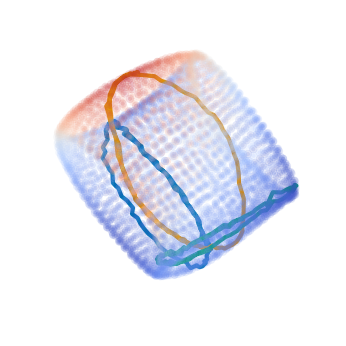

In [6]:
from plotting_functions import set_size

figsize = set_size(fraction=(1/5,1/5),mode='square')

# 3d plot using matplotlib
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], c=activities[:,0], cmap='coolwarm', alpha=0.15, s=1)
# add trajectory
ax.plot(low_dim_trajectory[:,0], low_dim_trajectory[:,1], low_dim_trajectory[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory2[:,0], low_dim_trajectory2[:,1], low_dim_trajectory2[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory3[:,0], low_dim_trajectory3[:,1], low_dim_trajectory3[:,2])#, lw=5)#, color='black')
random_elev_offset = np.random.randint(0, 360)
random_azim_offset = np.random.randint(0, 360)
ax.view_init(elev=0+random_elev_offset, azim=0+random_azim_offset)
ax.axis('off')
ax.axis('equal')

fraction = -0.12
mmin, mmax = low_dim_activities.min(0), low_dim_activities.max(0)
ax.set_xlim(mmin[0] - fraction * (mmax[0] - mmin[0]), mmax[0] + fraction * (mmax[0] - mmin[0]))
ax.set_ylim(mmin[1] - fraction * (mmax[1] - mmin[1]), mmax[1] + fraction * (mmax[1] - mmin[1]))
ax.set_zlim(mmin[2] - fraction * (mmax[2] - mmin[2]), mmax[2] + fraction * (mmax[2] - mmin[2]))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

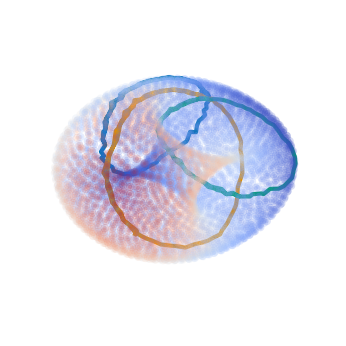

In [7]:
from plotting_functions import set_size

figsize = set_size(fraction=(1/5,1/5),mode='square')

# 3d plot using matplotlib
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], c=activities[:,0], cmap='coolwarm', alpha=0.2, s=1)
# add trajectory
ax.plot(low_dim_trajectory[:,0], low_dim_trajectory[:,1], low_dim_trajectory[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory2[:,0], low_dim_trajectory2[:,1], low_dim_trajectory2[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory3[:,0], low_dim_trajectory3[:,1], low_dim_trajectory3[:,2])#, lw=5)#, color='black')
# set the two view parameters: azimuth and elevation
ax.view_init(elev=90+random_elev_offset, azim=0+random_azim_offset)
ax.axis('off')
ax.axis('equal')

fraction = -0.12
mmin, mmax = low_dim_activities.min(0), low_dim_activities.max(0)
ax.set_xlim(mmin[0] - fraction * (mmax[0] - mmin[0]), mmax[0] + fraction * (mmax[0] - mmin[0]))
ax.set_ylim(mmin[1] - fraction * (mmax[1] - mmin[1]), mmax[1] + fraction * (mmax[1] - mmin[1]))
ax.set_zlim(mmin[2] - fraction * (mmax[2] - mmin[2]), mmax[2] + fraction * (mmax[2] - mmin[2]))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

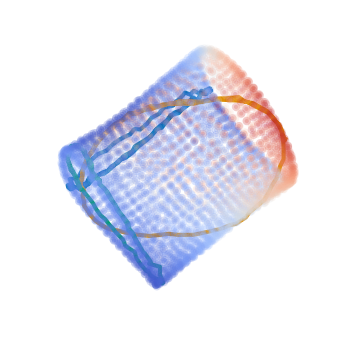

In [8]:
from plotting_functions import set_size

figsize = set_size(fraction=(1/5,1/5),mode='square')

# 3d plot using matplotlib
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], c=activities[:,0], cmap='coolwarm', alpha=0.2, s=1)
# add trajectory
ax.plot(low_dim_trajectory[:,0], low_dim_trajectory[:,1], low_dim_trajectory[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory2[:,0], low_dim_trajectory2[:,1], low_dim_trajectory2[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory3[:,0], low_dim_trajectory3[:,1], low_dim_trajectory3[:,2])#, lw=5)#, color='black')
# set the two view parameters: azimuth and elevation
ax.view_init(elev=0+random_elev_offset, azim=90+random_azim_offset)
ax.axis('off')
ax.axis('equal')

fraction = -0.12
mmin, mmax = low_dim_activities.min(0), low_dim_activities.max(0)
ax.set_xlim(mmin[0] - fraction * (mmax[0] - mmin[0]), mmax[0] + fraction * (mmax[0] - mmin[0]))
ax.set_ylim(mmin[1] - fraction * (mmax[1] - mmin[1]), mmax[1] + fraction * (mmax[1] - mmin[1]))
ax.set_zlim(mmin[2] - fraction * (mmax[2] - mmin[2]), mmax[2] + fraction * (mmax[2] - mmin[2]))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

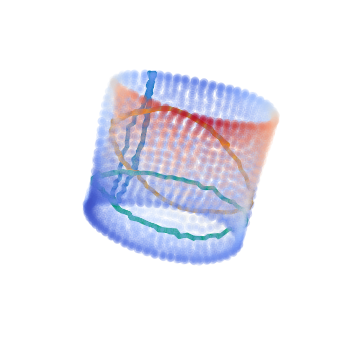

In [9]:
from plotting_functions import set_size

figsize = set_size(fraction=(1/5,1/5),mode='square')

# 3d plot using matplotlib
fig = plt.figure(figsize=figsize, dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(low_dim_activities[:,0], low_dim_activities[:,1], low_dim_activities[:,2], c=activities[:,0], cmap='coolwarm', alpha=0.2, s=1)
# add trajectory
ax.plot(low_dim_trajectory[:,0], low_dim_trajectory[:,1], low_dim_trajectory[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory2[:,0], low_dim_trajectory2[:,1], low_dim_trajectory2[:,2])#, lw=5)#, color='black')
ax.plot(low_dim_trajectory3[:,0], low_dim_trajectory3[:,1], low_dim_trajectory3[:,2])#, lw=5)#, color='black')
# set the two view parameters: azimuth and elevation
ax.view_init(elev=45+random_elev_offset, azim=45+random_azim_offset)
ax.axis('off')
ax.axis('equal')

fraction = -0.12
mmin, mmax = low_dim_activities.min(0), low_dim_activities.max(0)
ax.set_xlim(mmin[0] - fraction * (mmax[0] - mmin[0]), mmax[0] + fraction * (mmax[0] - mmin[0]))
ax.set_ylim(mmin[1] - fraction * (mmax[1] - mmin[1]), mmax[1] + fraction * (mmax[1] - mmin[1]))
ax.set_zlim(mmin[2] - fraction * (mmax[2] - mmin[2]), mmax[2] + fraction * (mmax[2] - mmin[2]))

padding = 0.0
ax.set_position([-padding, -padding, 1+padding, 1+padding])
ax.patch.set_alpha(0)

In [10]:
grids.unit_cell.is_in_hexagon(rs_trajectory2)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

(-9.42477796076938, 9.42477796076938, -9.42477796076938, 9.42477796076938)

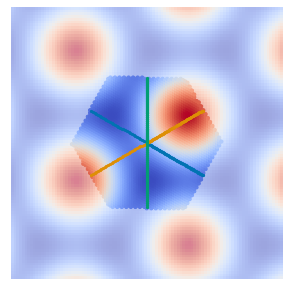

In [11]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))
center=grids.phases[0].detach().numpy()
ax.scatter(*rs[~mask].T, c=activities[:,0], s=10, cmap='coolwarm')
ax.scatter(*grids.unit_cell.wrap(rs_trajectory).T, s=5)
ax.scatter(*grids.unit_cell.wrap(rs_trajectory2).T, s=5)
#ax.scatter(*(rs_trajectory2[~grids.unit_cell.is_in_hexagon(rs_trajectory2)]).T, s=5,alpha=0.1)
ax.scatter(*grids.unit_cell.wrap(rs_trajectory3).T, s=5)
ax.set_xlim(-boxsize, boxsize)
ax.set_ylim(-boxsize, boxsize)
square_activities = grids(torch.tensor(rs_square_mesh).float()).detach().numpy()
ax.imshow(square_activities[:,0].reshape(100, 100), extent=(-boxsize, boxsize, -boxsize, boxsize), cmap='coolwarm', alpha=0.5, origin='lower')
ax.axis('equal')
ax.axis('off')